# Group Project Report

Group: 83
<br> Guozheng Gong, Brianna Zhou, Saakshith Manjunath, Hrishikesh Rakeshkumar Dalal

### Title: A Model for the Prediction of Heart Disease
### Introduction:
We are using the Cleveland Heart Disease dataset found in the UCI Machine Learning Repository, which consists of 14 variables. 
 
Heart disease is one of the leading causes of death around the world. The most common risk factors that cause heart disease are high blood pressure, cholesterol, heart rate and age *(Centers for Disease Control and Prevention, 2020; Palatini, 2011; National Institute on Aging, 2018)*. 

Since these columns are shown to have a stronger relationship with heart disease, we will use them to choose our predictors instead of the other columns that have a weaker relationship with heart disease.
 
The column names are as follows:
- `trestbps`: resting blood pressure (in mm Hg)
- `chol`: serum cholesterol (in mg/dl)
- `thalach`: maximum heart rate achieved (beats per minute, bpm)
- `age`: age (in years)
 
Predictive question: Can we use a person’s vital signs to predict whether they have heart disease?


### Methods & Results:

**Loading the libraries and setting the seed:**

In [1]:
library(tidyverse) #First run this to load the packages
library(tidymodels)
set.seed(4321)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

**Downloading and reading the data:**

The data set does not contain the column names, so we are specifying the column names by referring to the UCI repository.

In [2]:
download.file(url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", 
              destfile = "data/processed.cleveland.data")
heart_data <- read_csv(file = "data/processed.cleveland.data", 
                 col_names = c("age","sex","cp","trestbps","chol","fbs","restecg","thalach",
                               "exang","oldpeak","slope","ca","thal","num_the_predicted_attribute"))

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


**Let's look at the data:**

In [3]:
head(heart_data)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num_the_predicted_attribute
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


Table 1: Taking a look at the first few rows of the heart disease dataset

With this model, we are trying to predict if the person has heart disease or not. This is a categorical variable and it can have only two possible values: 0 (if the person does not have heart disease) and 1 (if the person has heart disease). So for our purposes, values 1,2,3,4 have the same meaning (presence of heart disease), so we are converting the values 2,3,4 in `num_the_predicted_attribute` to 1. 

In [4]:
heart_data1 <- filter(heart_data, num_the_predicted_attribute <=1)
heart_data2 <- filter(heart_data, num_the_predicted_attribute > 1)
heart_data2 <- mutate(heart_data2, num_the_predicted_attribute = 1)
heart_data <- merge(heart_data1, heart_data2, all = T)

**Changing `num_the_predicted_attribute` to be a factor**

In [5]:
heart_data <- mutate(heart_data, num_the_predicted_attribute = as_factor(num_the_predicted_attribute))

**Selecting only the columns we need**

In [6]:
heart_data <- select(heart_data, age, trestbps, chol, thalach, num_the_predicted_attribute)
head(heart_data)

,age,trestbps,chol,thalach,num_the_predicted_attribute
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,29,130,204,202,0
2,34,118,210,192,0
3,34,118,182,174,0
4,35,138,183,182,0
5,35,122,192,174,0
6,35,120,198,130,1


Table 2: Dataset with only the columns we will consider to choose our predictors

Now, we are splitting our data set into training and testing data.

In [7]:
#We are using 75% of the data as training data.
heart_data_split <- initial_split(heart_data, prop = 0.75, strata = num_the_predicted_attribute)  
heart_data_train <- training(heart_data_split)   
heart_data_test <- testing(heart_data_split)

Computing the mean of each of the columns for every possible predicted value:

In [8]:
summary_data <- group_by(heart_data_train,num_the_predicted_attribute) |>
    summarize(trestbps_mean = mean(trestbps), 
              chol_mean = mean(chol),
              age_mean = mean(age),
              thalach_mean=mean(thalach))
summary_data

num_the_predicted_attribute,trestbps_mean,chol_mean,age_mean,thalach_mean
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
0,128.8049,244.7886,52.52033,157.7236
1,133.4423,248.7885,55.66346,139.2500


Table 3: Summary table for the columns in the dataset

According to our summary table above, the columns `chol` and `thalach` have a  larger difference in mean values for people with and without the disease. This could help the model differentiate better between the two outcomes, rather than including other columns that have similar values for both cases. This is why we are choosing them as our predictors.


**Counting the missing data in each column:**

In [9]:
missing_data <- heart_data |>
     map_df(is.na) |>
     map_df(sum)
missing_data

age,trestbps,chol,thalach,num_the_predicted_attribute
<int>,<int>,<int>,<int>,<int>
0,0,0,0,0


Table 4: Checking for missing data

It looks like there is no missing data.

**Visualization: Cholesterol vs. Heart rate scatter plot**

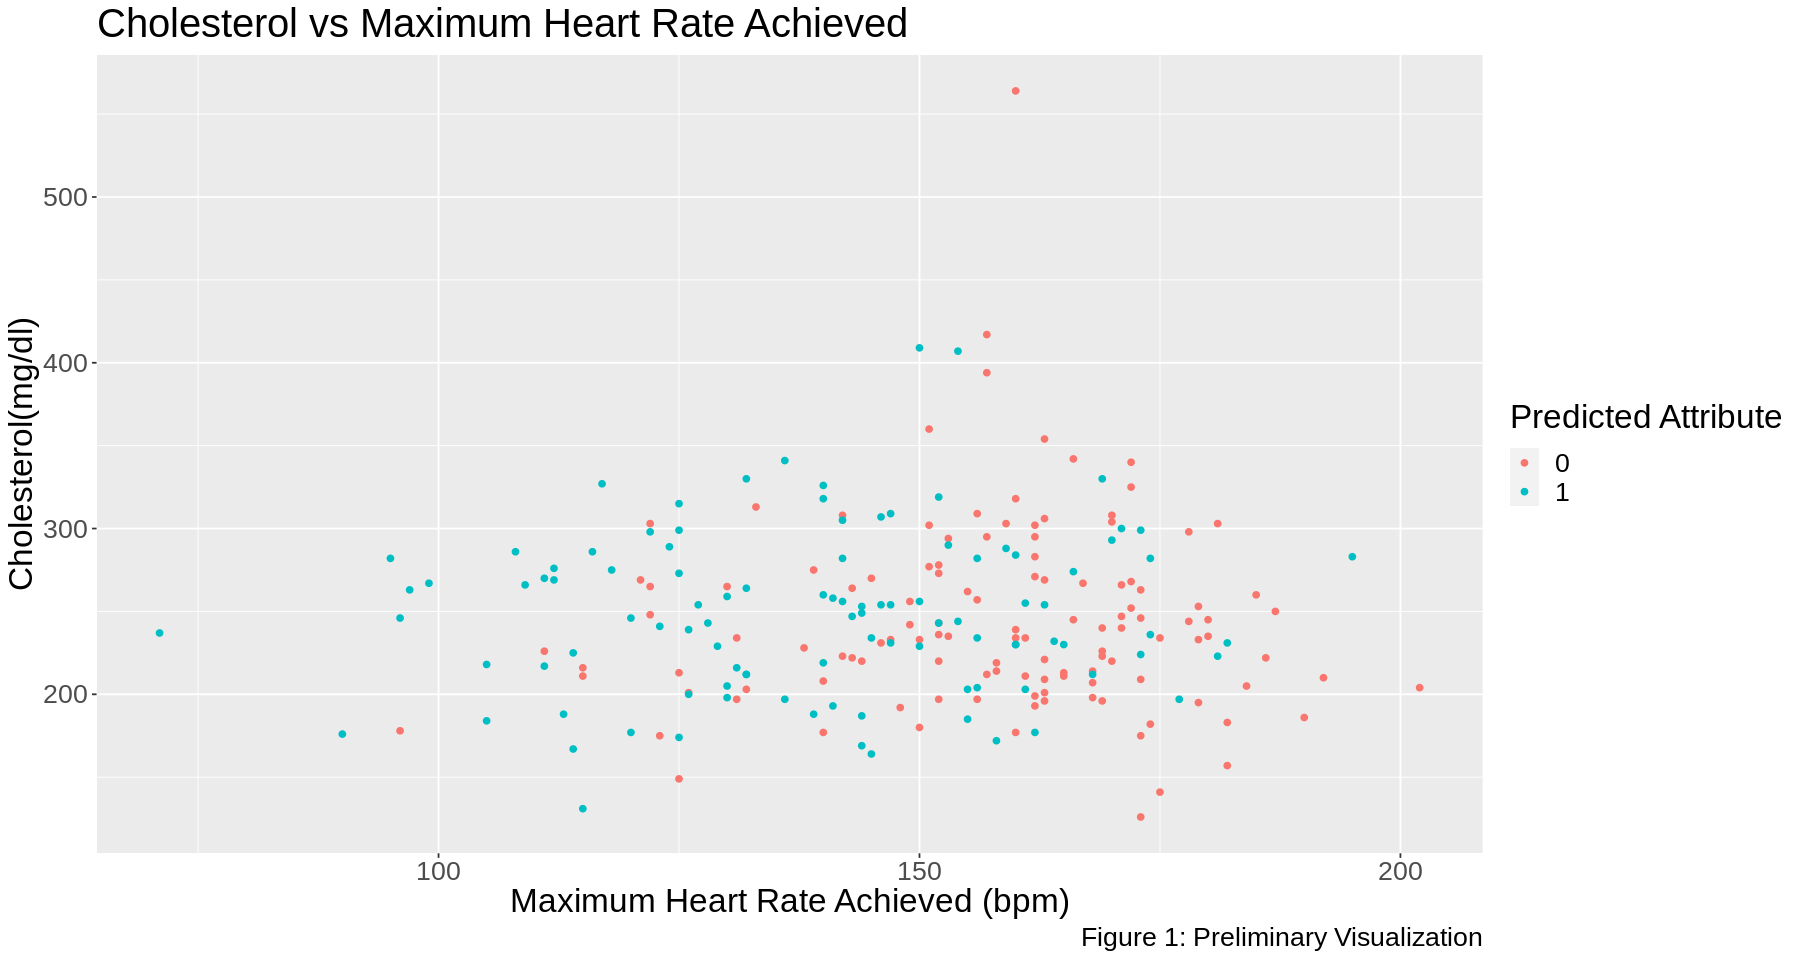

In [10]:
options(repr.plot.width = 15, repr.plot.height = 8) 

chol_v_hr_plot <- heart_data_train |>
ggplot(aes(x = thalach, y = chol, colour = num_the_predicted_attribute)) +
geom_point() +
labs(x = "Maximum Heart Rate Achieved (bpm)", y = "Cholesterol(mg/dl)", colour = "Predicted Attribute",
    caption = "Figure 1: Preliminary Visualization") +
ggtitle("Cholesterol vs Maximum Heart Rate Achieved") +
theme(text=element_text(size=20))

chol_v_hr_plot

From the scatterplot, there does not seem to be any relationship between the two variables, Cholesterol and Maximum Heart Rate Achieved. However, we can observe that  most of the red points lie between a heart rate of 150-200 bpm and the most of the blue points lie between 100-150 bpm. So according to our data, people without heart disease seem to have a higher heart rate than the people with heart disease (on average).

**Making the receipe and preprocessing the data:**

We are centering and scaling the predictors so that each predictor is on a comparable scale.

In [11]:
knn_recipe <- recipe(num_the_predicted_attribute ~ ., data = heart_data_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

**Training the model:**

In [12]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

**Cross-validation:**

We are doing 10 fold cross-validation for our training data to find the best value of K ranging from 1 to 20. 

In [13]:
heart_vfold <- vfold_cv(heart_data_train, v = 10, strata = num_the_predicted_attribute)
gridvals <- tibble(neighbors = 1:20)
results <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = heart_vfold, grid = gridvals) |>
    collect_metrics()

**Plotting K vs Accuracy:**

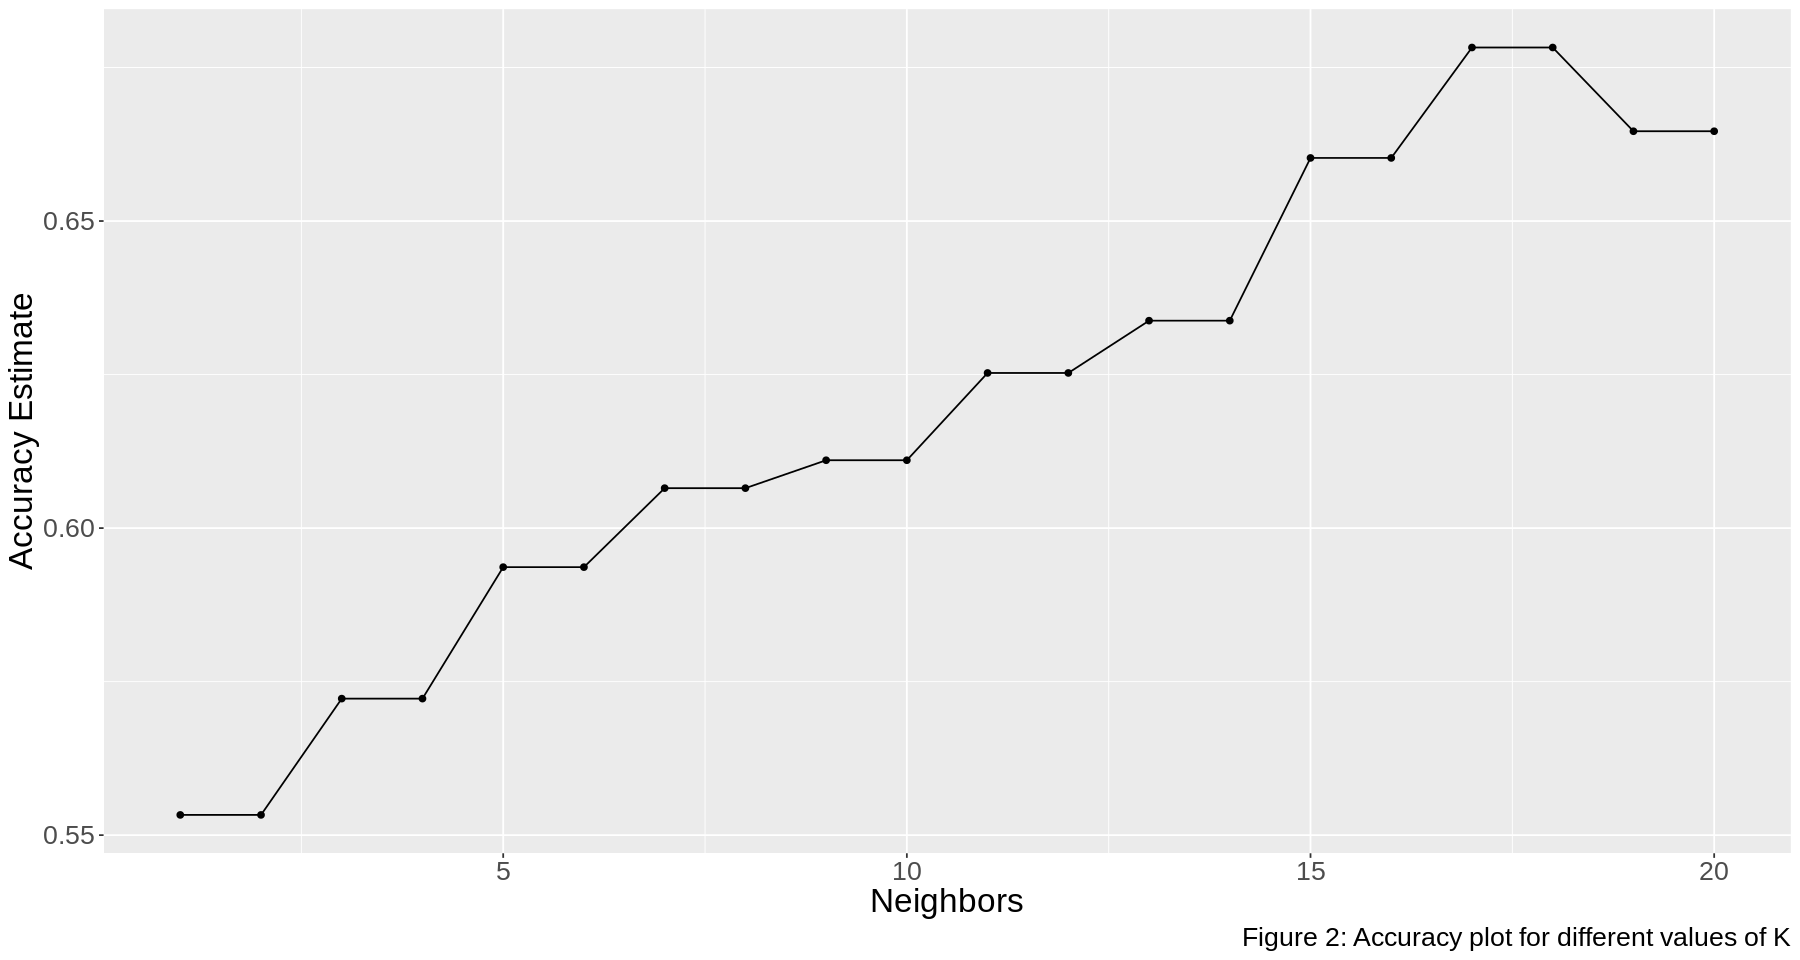

In [14]:
accuracies <- results |>
      filter(.metric == "accuracy")
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", caption = "Figure 2: Accuracy plot for different values of K") +
      theme(text=element_text(size=20))
cross_val_plot

From this graph we can see neighbors = 17 should be a good choice because it has a high accuracy estimate and the accuracy does not change much for nearby values of K. Choosing a higher value can be computationally expensive. So, we will use K = 17.

**Retraining our classifier with the chosen K:**

In [15]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 17) |>
      set_engine("kknn") |>
      set_mode("classification")

heart_fit <- workflow() |>
      add_recipe(knn_recipe) |>
      add_model(knn_spec) |>
      fit(data = heart_data_train)

**Testing our model:**

In [16]:
heart_test_predictions <- predict(heart_fit , heart_data_test) |>
      bind_cols(heart_data_test)

**Assessing the accuracy of the model:**

In [17]:
heart_prediction_accuracy <- heart_test_predictions |>
        metrics(truth = num_the_predicted_attribute, estimate =.pred_class )  
heart_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7763158
kap,binary,0.5507650


Table 5: Metrics for the model

**Making the confusion matrix:**

In [18]:
heart_mat <- heart_test_predictions |> 
      conf_mat(truth = num_the_predicted_attribute, estimate =.pred_class)
heart_mat

          Truth
Prediction  0  1
         0 32  8
         1  9 27

**Visualization: Making a bar graph to visualize the confusion matrix**

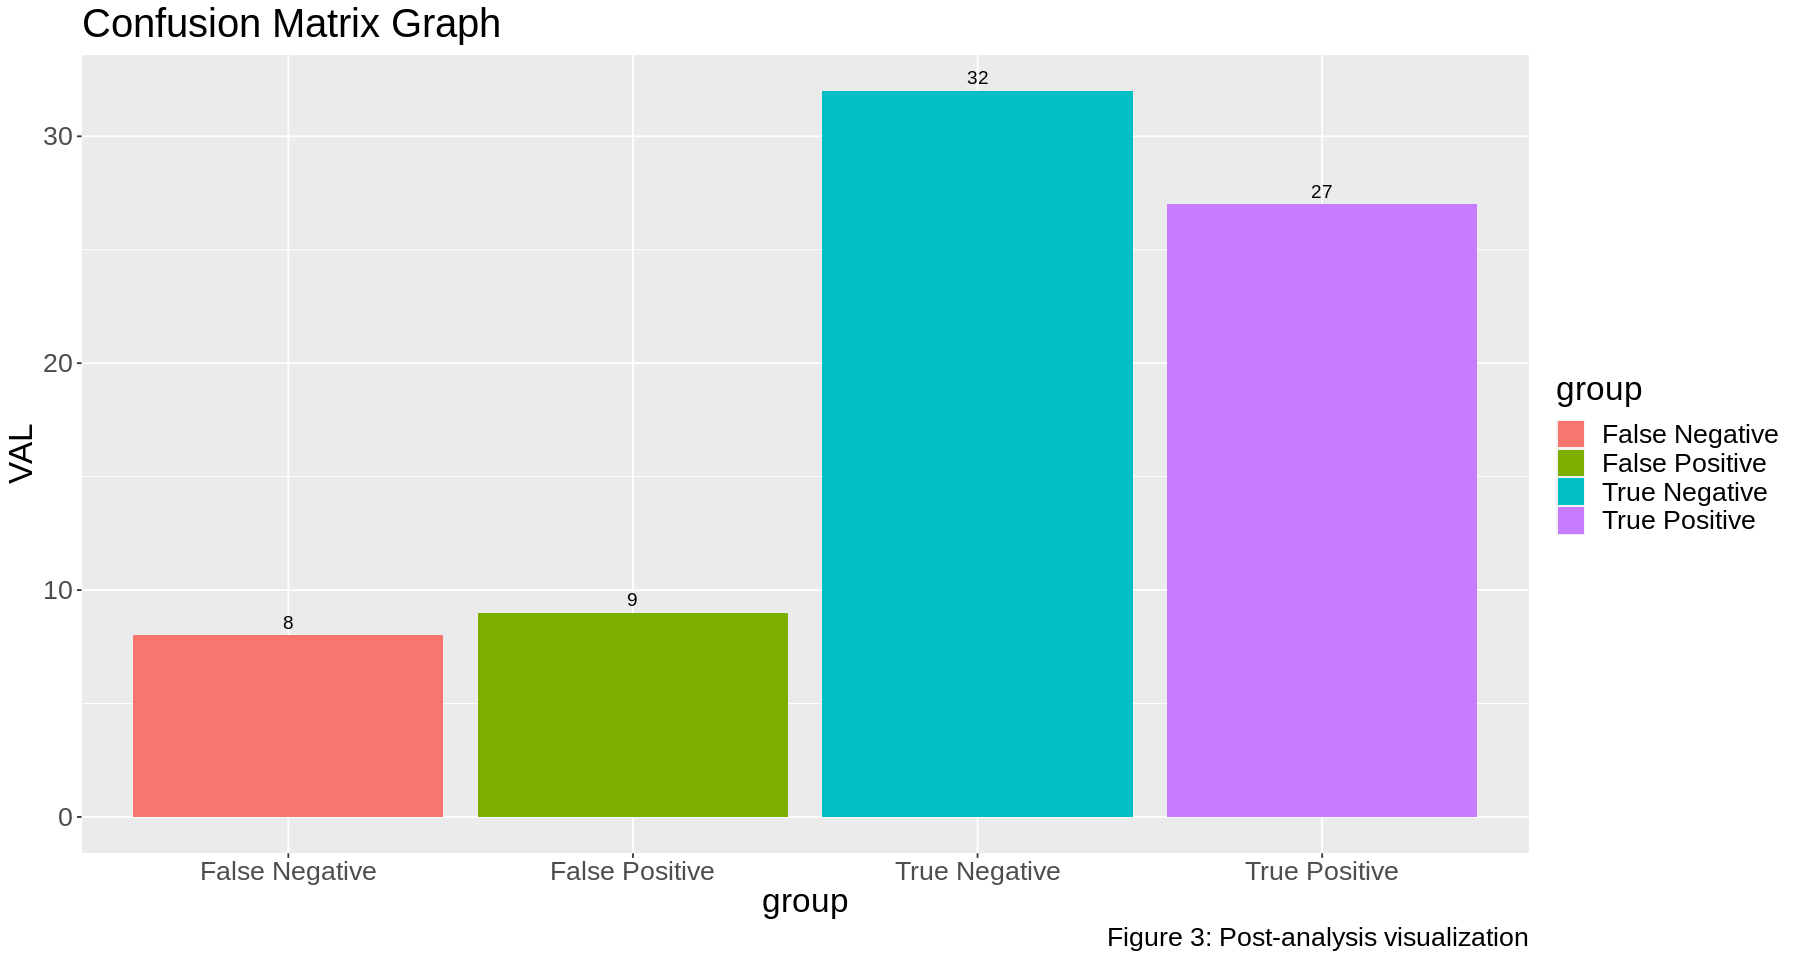

In [19]:
data.frame(group=c("True Positive", "False Negative", "True Negative", "False Positive"), VAL=c(27,8,32,9)) |>
    ggplot(aes(x=group,y=VAL,fill=group))+
  geom_bar(stat = "identity")+
  geom_text(aes(label=VAL),size=4,vjust=-0.5)+
  labs(caption = "Figure 3: Post-analysis visualization") +
  ggtitle("Confusion Matrix Graph") +
  theme(text=element_text(size=20))

In the above plot:
- True Positive: Predicted class = 1, Actual class = 1 (People with heart disease classified correctly)
- False Negative: Predicted class = 0, Actual class = 1 (People with heart disease classified incorrectly)
- True Negative: Predicted class = 0, Actual class = 0 (People without heart disease classified correctly)
- False Positive: Predicted class = 1, Actual class = 0 (People without heart disease classified incorrectly)

There were 32 “0”s (people without heart disease) predicted correctly and 9 “0”s were predicted incorrectly. Further, there were 27 “1”s (people with heart disease) predicted correctly and 8 “1”s were predicted incorrectly.

### Discussion:

**Summary of findings:**

From our data, it is reasonable to infer that people without heart disease seem to have a higher heart rate than the people with heart disease (on average). We found out that using cholesterol and heart rate as predictors to determine whether a given person has a heart disease or not gives us a model which has approximately 77% accuracy. Choosing the number of neighbors K = 17, our model was able to predict the labels of 59 observations correctly (32 “0”s were predicted correctly and 27 “1”s were predicted correctly). However, it incorrectly predicted 9 “0”s as “1” and 8 “1”s as “0”, which is still a significant portion of data. Therefore, although the model has a pretty good accuracy, it cannot be used in a clinical setting because incorrectly predicting whether a person has heart disease or not can be fatal. So we would need a better model in practice. 


**Comparing results with expectations:**

Our data depicts that people without heart diseases seem to have a higher heart rate than the people with heart disease (on average). On the contrary, epidemiological studies suggest that a higher heart rate is linked to a greater risk of heart diseases and cardiovascular events *(Palatini, 2011)*. This makes us question the relationship between a person’s heart rate and heart disease *(Zhang et al., 2016)*. Cholesterol continues to remain a major factor in the contribution of heart diseases, as expected. 

**Impact of the findings:**

These findings could have a major impact on the food consumption choices made by the people. People would become more aware of the fact that excessive consumption of cholesterol can contribute to heart diseases. This would in turn lead to better and more conscious food choices. 

**Future questions:**

This leaves us with a question of whether increasing heart rate contributes to heart diseases or not, as the findings of our model contradict the findings from epidemiological studies. This leads to the following questions:

- “What if the presence of heart disease in a person is independent of the resting heart rate?” 
- “What other predictors can be used to predict if the person has heart disease?”


### References

1. Centers for Disease Control and Prevention. (2020, October 7). Heart Disease and Stroke. Www.cdc.gov. https://www.cdc.gov/chronicdisease/resources/publications/factsheets/heart-disease-stroke.htm#:~:text=Leading%20risk%20factors%20for%20heart

2. Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

3. National Institute on Aging. (2018, June 1). Heart Health and Aging. National Institute on Aging. https://www.nia.nih.gov/health/heart-health-and-aging

4. Palatini, P. (2011). Role of elevated heart rate in the development of cardiovascular disease in hypertension. Hypertension, 58(5), 745-750.

5. Zhang, D., Wang, W., & Li, F. (2016). Association between resting heart rate and coronary artery disease, stroke, sudden death and noncardiovascular diseases: a meta-analysis. CMAJ : Canadian Medical Association journal = journal de l'Association medicale canadienne, 188(15), E384–E392. https://doi.org/10.1503/cmaj.160050


